In [13]:
import numpy as np
from tqdm import tqdm
import random
from system import (
    states,
    actions, 
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    to_state,
    get_valid_actions,
    gen_random_sa,
    rows,
    cols
)
from model import Model
from policy import Policy, PolicyInit
from agent import Agent

In [15]:
def ch_egreedy(epsilon, Q, s):
    p = np.zeros(num_actions)
    valid_actions = get_valid_actions(to_state(s), idx=True)
    va = len(valid_actions)
    # print(va)
    p[valid_actions] = epsilon / va
    validqsa = Q[s][valid_actions]
    p[valid_actions[np.argmax(validqsa)]] += 1 - epsilon
    choice = np.random.choice(np.arange(num_actions), p=p)
    return choice

In [14]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=100)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [16]:
Q_val = np.random.uniform(-10, 0, (num_states, num_actions))
# for a in range(num_actions):
#     Q_val[37][a] = 0
# Q_val = np.zeros((num_states, num_actions))
returns = [[[] for a in range(num_actions)] for s in range(num_states)]
# valf_list = [(np.max(Q_val, axis=1))]

i = 0
T = 100
gamma = 0.9
alpha = 0.1
epsilon = 0.9
for i in tqdm(range(1000)):
    start_state = random.randint(0, num_states-1)
    state = start_state
    while True:
        action = ch_egreedy(epsilon, Q_val, state)
        nstate = model.gen_next(to_state(state), action)
        r = model.get_reward(to_state(state), nstate)
        valid_actions = get_valid_actions(nstate, idx=True)
        validqsa = Q_val[to_idx(nstate)][valid_actions]
        nmax= np.max(validqsa)
        Q_val[state][action] = Q_val[state][action] + alpha * ((r + gamma * nmax) - Q_val[state][action])
        if state == 37:
            break
        state = to_idx(nstate)

100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]


In [28]:
valf = np.max(Q_val, axis=1)
for s in range(num_states):
    valid_actions = get_valid_actions(to_state(s), idx=True)
    action = valid_actions[np.argmax(Q_val[s][valid_actions])]
    policy.set_action(to_state(s), action)
agent.change_policy(policy)

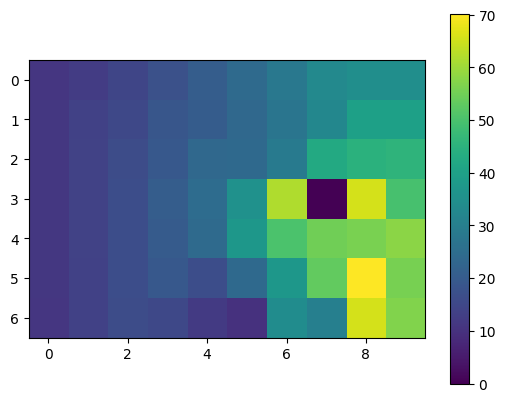

In [29]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

In [30]:
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [0 1], Next State: [3 1], Reward: -1
State: [3 1], Action: [0 1], Next State: [3 2], Reward: -1
State: [3 2], Action: [1 1], Next State: [4 3], Reward: -1
State: [4 3], Action: [0 1], Next State: [3 4], Reward: -1
State: [3 4], Action: [1 1], Next State: [2 5], Reward: -1
State: [2 5], Action: [1 0], Next State: [3 5], Reward: -1
State: [3 5], Action: [1 1], Next State: [3 6], Reward: -1
State: [3 6], Action: [1 1], Next State: [3 7], Reward: 100
Game Over - Score: 93


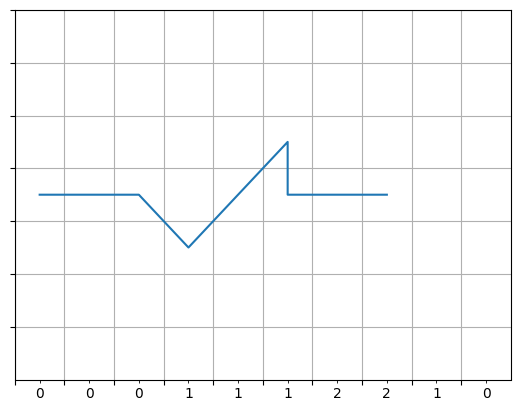

In [31]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()